In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# Example code from Dr. Tward

In [2]:
nrows = 64
ncols = 65 
# in test cases I make rows and columns different numbers
# in case there are any bugs where we mix up rows and columns

<IPython.core.display.Javascript object>


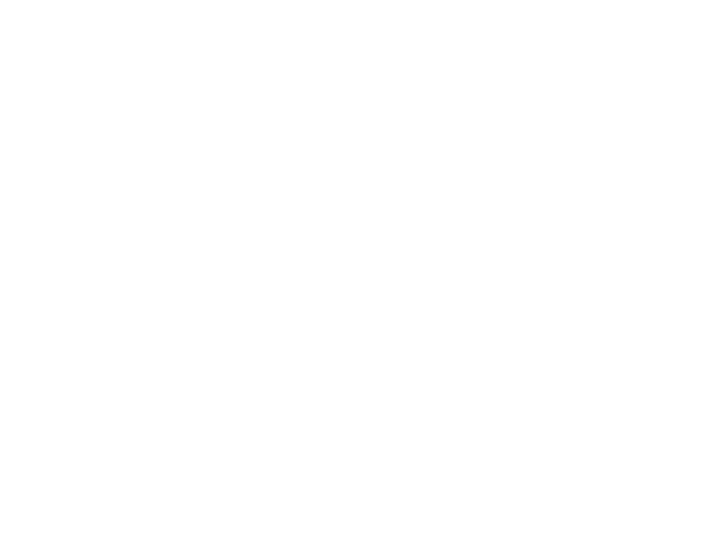

In [3]:
# initialize an image
I = np.zeros((nrows,ncols))

# draw it
fig,ax = plt.subplots()
ax.imshow(I,cmap='gray')

<IPython.core.display.Javascript object>


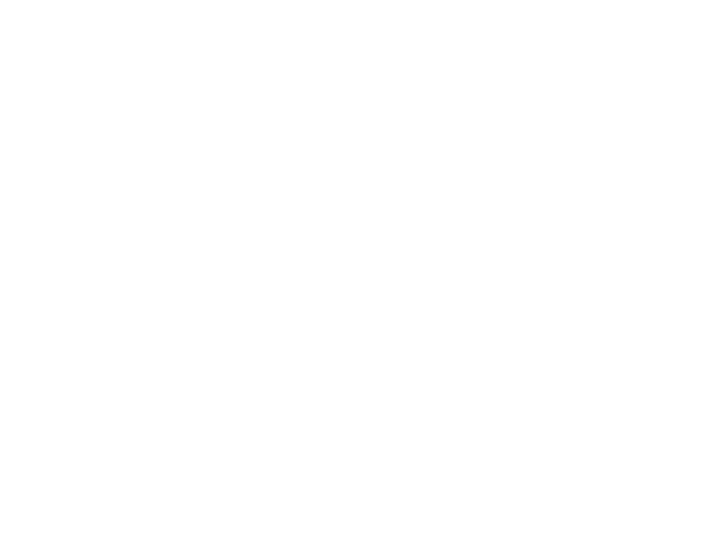

In [4]:
# get the locations of every pixel so we can insert cells at certain locations
r = np.arange(nrows)
c = np.arange(ncols)
r,c
# to get the row and column of every pixel, we use meshgrid
R,C = np.meshgrid(r,c,indexing='ij')
fig,ax = plt.subplots(1,2)
ax[0].imshow(R)
ax[1].imshow(C)
# R stores the row of every pixel, and C stores the column of every pixel

In [5]:
# let's put a cell at the location (20,30)
radius = 5
I += (R - 20)**2 + (C - 30)**2 <= radius**2

<IPython.core.display.Javascript object>


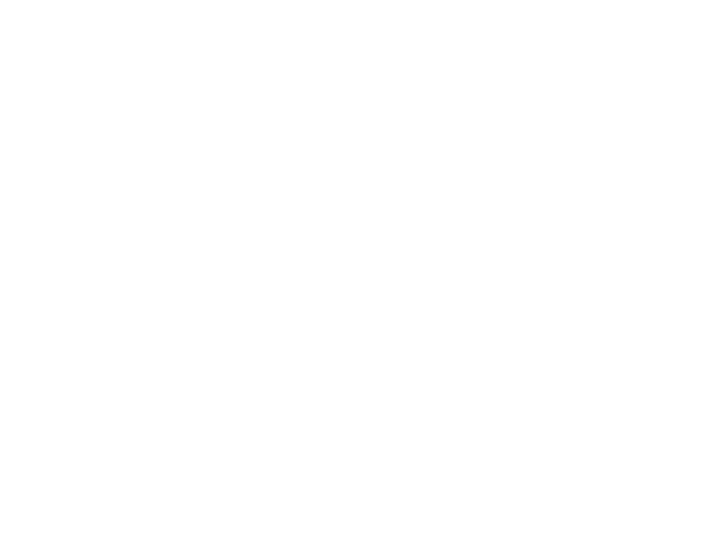

In [6]:
fig,ax = plt.subplots()
ax.imshow(I,cmap='gray')

# Creation of Simulated Images

In [7]:
# goal is to repeat this so that you have a bunch of cells in two different images, covering the four cases

<IPython.core.display.Javascript object>


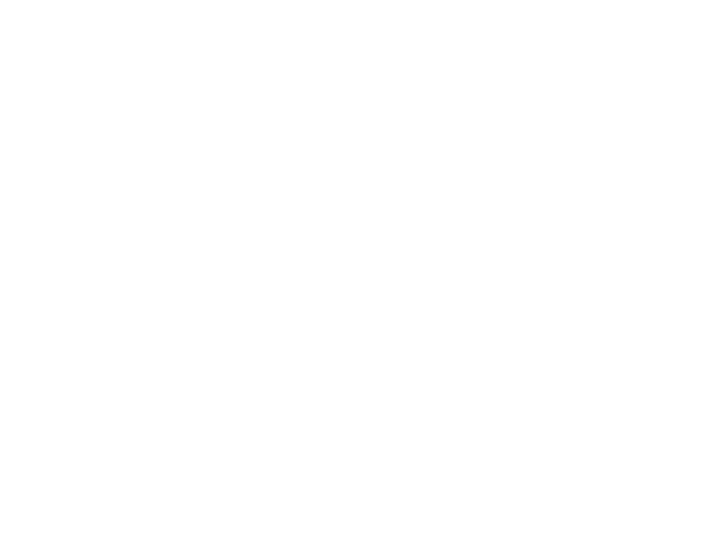

In [8]:
nrows = 128
ncols = 129

# initialize empty images
I1 = np.zeros((nrows,ncols))
I2 = np.zeros((nrows,ncols))

# to get the row and column of every pixel, we use meshgrid
r = np.arange(nrows)
c = np.arange(ncols)
R,C = np.meshgrid(r,c,indexing='ij')

# Constant radius across all cells
radius = 8

# Define coordinate center of each cell
cellPos = np.array([[20,30],[100,80],[60,20],[110,40],[50,60],[20,120],[15,70],[70,90]])
cellIDs = np.arange(1,len(cellPos)+1,1)

# Insertion of cells onto empty image
for coords,id_number in zip(cellPos,cellIDs):
    I1 += ((R - coords[0])**2 + (C - coords[1])**2 <= radius**2)*id_number

# Definition of bounding box circles
cirPos = np.array([[10,10],[98,77],[50,18],[110,30],[13,68],[60,110]])
cirIDs = np.arange(1,len(cirPos)+1,1)

# Insertion of bounding boxes onto cell image
# I2 = I1.copy()
for coords,id_number in zip(cirPos,cirIDs):
    I2 += ((R - coords[0])**2 + (C - coords[1])**2 <= radius**2)*id_number

I1 = I1.astype(int)
I2 = I2.astype(int)

# Display GT and Prediction images
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.title.set_text('Ground Truth')
ax1.imshow(I1,cmap='gray')
ax2.title.set_text('Predictions')
ax2.imshow(I2,cmap='gray')

<IPython.core.display.Javascript object>


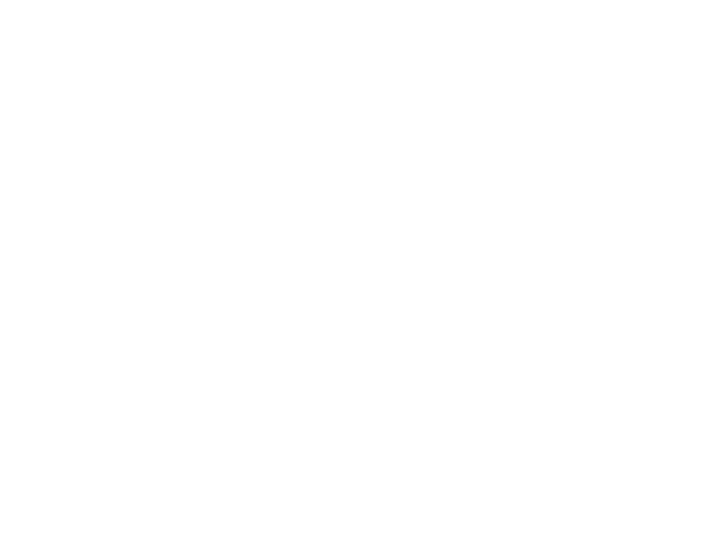

In [9]:
fig,ax = plt.subplots()
ax.title.set_text('GT + Prediction')
ax.imshow(I1+I2)

Case 1: a good match, where they agree almost completely
- GT cell located at [15,70], [100,80]
- Predict located at [12,68], [98,77]

Case 2: a bad match, where they overlap only partially
- GT cell located at [60,20], [110,40]
- Predict located at [50,18], [110,30]

Case 3: a false positive, where a predicted cell is in the wrong spot
- GT cell located at [20,30], [70,90]
- Predict located at [10,10], [60,110]

Case 4: a false negative, where a ground truth cell is missed completely
- GT cell located at [50,60], [20,120]

## Calculation of Precision and Recall

Metric definitions:
- TP: A point **DOES** have a cell and was **CORRECTLY** predicted
- TN: A point does **NOT** have a cell and was **CORRECTLY** predicted
- FP: A point does **NOT** have a cell and was **INCORRECTLY** predicted
- FN: A point **DOES** have a cell and was **INCORRECTLY** predicted

In [10]:
def metrics(I1,I2):
    if I1.shape != I2.shape:
        print("Error: Invalid input shape")
        return 0
    
    TP,TN,FP,FN = [0,0,0,0]

    for rVal in np.arange(I1.shape[0]):
        for cVal in np.arange(I1.shape[1]):
            i1 = I1[rVal][cVal]
            i2 = I2[rVal][cVal]

            if i1 > 0 and i2 > 0:
                TP+=1
            elif i1 == 0 and i2 == 0:
                TN+=1
            elif i1 == 0 and i2 > 0:
                FP+=1
            elif i1 > 0 and i2 == 0:
                FN+=1
            else:
                print('Missed case: (%i,%i)',i1,i2) 

    return [TP,TN,FP,FN]

def accuracy (TP,TN,FP,FN):
    return (TP+TN) / (TP+TN+FP+FN)

def precision(TP,FP):
    return TP / (TP+FP)

def recall(TP,FN):
    return TP / (TP+FN)

def fpr(FP,TN):
    return FP / (FP+TN)

def f1score(TP,FP,FN):
    return 2*recall(TP,FN)*precision(TP,FP)/(recall(TP,FN)+precision(TP,FP))

In [11]:
[TP,TN,FP,FN] = metrics(I1,I2)

print('accuracy:',accuracy(TP,TN,FP,FN))
print('precision:',precision(TP,FP))
print('recall:',recall(TP,FN))
print('fpr:',fpr(FP,TN))
print('f1score:',f1score(TP,FP,FN))

accuracy: 0.8800872093023255
precision: 0.3291032148900169
recall: 0.2468274111675127
fpr: 0.05309319764327799
f1score: 0.2820884699057288


## Bounding boxes over GT image

<IPython.core.display.Javascript object>


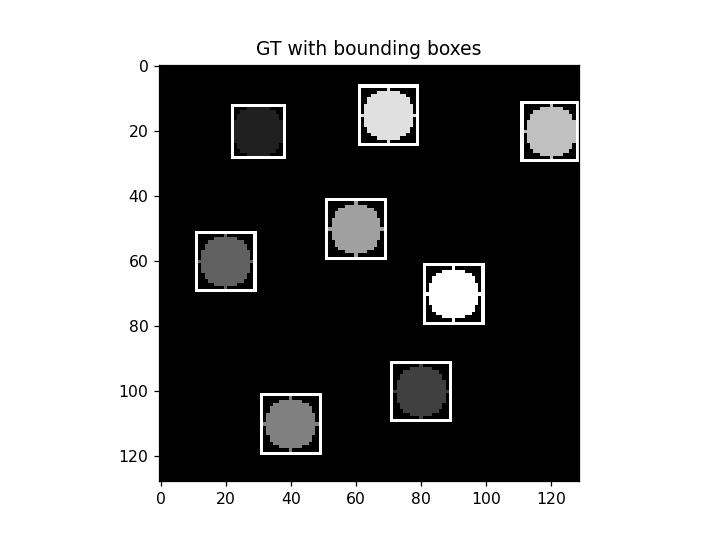

In [12]:
# Tutorial from https://muthu.co/draw-bounding-box-around-contours-skimage/

from skimage.measure import find_contours
from skimage.io import imread
%matplotlib notebook
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from skimage.draw import polygon_perimeter

# Image must be converted to grayscale before calling find_contours()
contours = find_contours(I1, 0.8)

# Generate bounding boxes of the form [Xmin, Xmax, Ymin, Ymax]
bounding_boxes = []

for contour in contours:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

# Creates copy of original grayscale image, which will be
with_boxes  = np.copy(I1)

for box in bounding_boxes:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1) #set box to highest int in image

fig,ax1 = plt.subplots();
ax1.title.set_text('GT with bounding boxes');
ax1.imshow(with_boxes,cmap='gray');

## Bounding boxes on GT + Predicted image

<IPython.core.display.Javascript object>


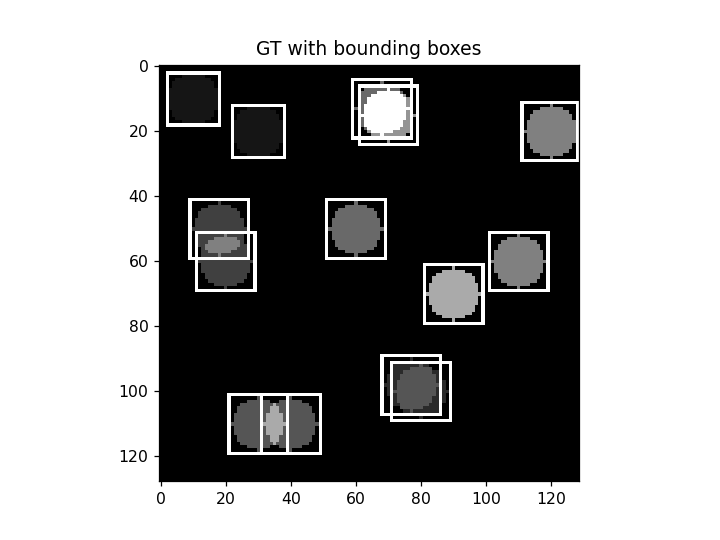

In [13]:
# Image must be converted to grayscale before calling find_contours()
contours_gt = find_contours(I1, 0.8)
contours_pred = find_contours(I2, 0.8)

# Generate bounding boxes of the form [Xmin, Xmax, Ymin, Ymax]
bounding_boxes_gt = []
bounding_boxes_pred = []

for contour in contours_gt:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes_gt.append([Xmin, Xmax, Ymin, Ymax])
    
for contour in contours_pred:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes_pred.append([Xmin, Xmax, Ymin, Ymax])

# Creates copy of original grayscale image, which will be
with_boxes  = np.copy(I1+I2)

for box in bounding_boxes_gt:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1+I2) #set box to highest int in image
    
for box in bounding_boxes_pred:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1+I2) #set box to highest int in image

fig,ax2 = plt.subplots();
ax2.title.set_text('GT with bounding boxes');
ax2.imshow(with_boxes,cmap='gray');

In [14]:
'''
box1 and box2 are bounding boxes of the form [Xmin, Xmax, Ymin, Ymax]
'''
def IOU(box1,box2):
    # determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[2], box2[2])
    x2 = min(box1[1], box2[1])
    y2 = min(box1[3], box2[3])
    
    # compute the area of intersection rectangle
    intersect = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    box1area = (box1[3]-box1[2])*(box1[1]-box1[0])
    box2area = (box1[3]-box1[2])*(box1[1]-box1[0])

    union = box1area+box2area+intersect
    
    return intersect/union

### Helper Functions for Performance Calculation

In [15]:
def count_metrics(bbgt,bbpred):
    TPgt,FPgt,FNgt = count_metrics_help(bbgt,"GT")
    TPpred,FPpred,FNpred = count_metrics_help(bbpred,"Pred")
    return TPgt+TPpred,FPgt+FPpred,FNgt+FNpred

def count_metrics_help(bb_set,bbType):
    countTP = 0;
    countFP = 0;
    countFN = 0;
    for bb in bb_set:
        if bb[1][1]=="TP":
            countTP+=1
        elif bb[1][1]=="FP":
            countFP+=1
        elif bb[1][1]=="FN":
            countFN+=1
        else:
            print("ERROR in count_metrics_help(): Invalid label in",bbType," : ",bb[1][1])
            print(bb); print()
    return countTP, countFP, countFN

def sumIOU(bbgt,bbpred):
    return sumIOU_help(bbgt)+sumIOU_help(bbpred)

def sumIOU_help(bb_set):
    IOU = 0
    for bb in bb_set:
        IOU += bb[1][0]
    return IOU

### Performance Calculation

0.10077700077700079 0.025893520810933192


<IPython.core.display.Javascript object>


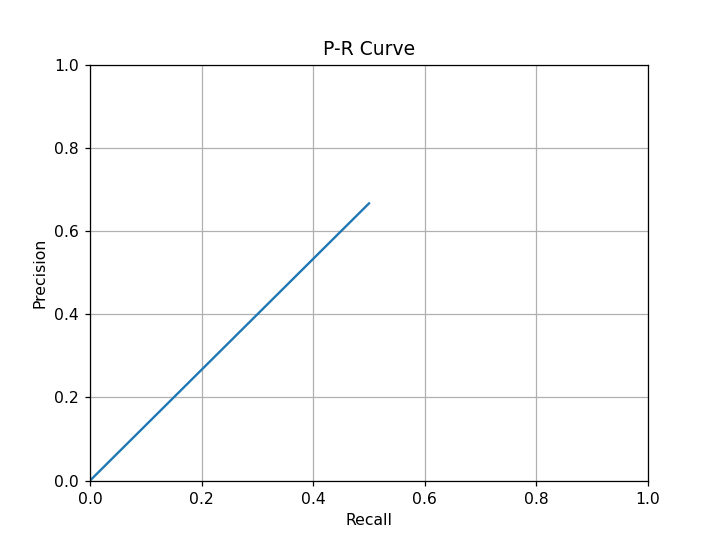

In [16]:
# Creates "empty" labels for each bb from the ground truth and predicted sets
gt_label = [[-1,"Unclassified"]]*len(bounding_boxes_gt)
pred_label = [[-1,"Unclassified"]]*len(bounding_boxes_pred)

# Defines empty lists to store relevant values
allAP = []
allIOU = []
precision = []
recall = []

# Loop over each threshold value from 0 to 1 with a step of 0.05
for Tk in np.arange(0,1.05,0.05):
    # Redefine G and P to have empty labels and refill missing bb from P
    G = list(map(list,zip(bounding_boxes_gt,gt_label)))
    P = list(map(list,zip(bounding_boxes_pred,pred_label)))
    
    # Label every gi as TP or FN and the remaining pi as FP
    for gi in G:
        prev_gi_label = gi[1]
        for pj in P:
            if IOU(gi[0],pj[0]) > Tk:
                gi[1] = [IOU(gi[0],pj[0]),"TP"]
                P.remove(pj)
        if prev_gi_label == gi[1]:
            gi[1] = [0,"FN"]
    for pi in P:
        pi[1] = [0,"FP"]

    # Compute and store metrics at interval Tk
    TP, FP, FN = count_metrics(G,P)
    #print(TP,FP,FN)
    
    allAP.append(TP/(TP+FP+FN))
    allIOU.append(sumIOU(G,P)/(len(G)+len(P)))
    precision.append(TP/(TP+FP))
    recall.append(TP/(TP+FN))

meanAP = sum(allAP)/len(allAP)
meanIOU = sum(allIOU)/len(allIOU)
        
print(meanAP, meanIOU)

fig,ax = plt.subplots();
ax.plot(recall,precision);
ax.grid()
ax.set_title('P-R Curve');
ax.set_xlabel("Recall"); ax.set_xlim(0, 1);
ax.set_ylabel("Precision"); ax.set_ylim(0, 1);